# NFL Prediction using Gradient Boosting Regressor



Sources : https://github.com/intro-stat-learning/ISLP_labs/blob/main/Ch08-baggboost-lab.ipynb \\
https://www.kaggle.com/code/kaba777/random-forest-model-lb-5-66  \\
https://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputRegressor.html \\
Gemini Pro 2.5

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import sklearn.model_selection as skm
from sklearn.model_selection import train_test_split


In [2]:
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR)
from sklearn.multioutput import MultiOutputRegressor


In [3]:
import glob
import os

# Data Loading

In [4]:
from pathlib import Path

# Check if /kaggle/input exists to determine if running on Kaggle
#if os.path.exists("/kaggle/input"):
    # On Kaggle notebook
    #DATA_DIR = Path("/kaggle/input/nfl-big-data-bowl-2026-prediction")
#else:
    # On local PC
    #DATA_DIR = Path("nfl-big-data-bowl-2026-prediction")

DATA_DIR = Path("nfl-big-data-bowl-2026-prediction")

# Load all CSV files from train folder
train_input_files = sorted(glob.glob(str(DATA_DIR /'train'/'input_*.csv')))
train_output_files = sorted(glob.glob(str(DATA_DIR /'train'/'output_*.csv')))

print(f'Input files: {len(train_input_files)}')
print(f'Output files: {len(train_output_files)}')

Input files: 0
Output files: 0


# Data Preprocessing

In [5]:
# Combine data
input_dfs = []
output_dfs = []

for input_file, output_file in zip(train_input_files, train_output_files):
    input_df = pd.read_csv(input_file)
    output_df = pd.read_csv(output_file)
    input_dfs.append(input_df)
    output_dfs.append(output_df)

train_input = pd.concat(input_dfs, ignore_index=True)
train_output = pd.concat(output_dfs, ignore_index=True)

print(f'Train input shape: {train_input.shape}')
print(f'Train output shape: {train_output.shape}')

ValueError: No objects to concatenate

In [ ]:
# Data Inspection
print("Input columns:")
print(train_input.columns.tolist())
print("\nOutput columns:")
print(train_output.columns.tolist())
print("\nInput sample:")
display(train_input.head())
print("\nOutput sample:")
display(train_output.head())

Input columns:
['game_id', 'play_id', 'player_to_predict', 'nfl_id', 'frame_id', 'play_direction', 'absolute_yardline_number', 'player_name', 'player_height', 'player_weight', 'player_birth_date', 'player_position', 'player_side', 'player_role', 'x', 'y', 's', 'a', 'dir', 'o', 'num_frames_output', 'ball_land_x', 'ball_land_y']

Output columns:
['game_id', 'play_id', 'nfl_id', 'frame_id', 'x', 'y']

Input sample:


,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,...,player_role,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y
0,2023090700,101,False,54527,1,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.94,0.09,0.39,322.40,238.24,21,63.259998,-0.22
1,2023090700,101,False,54527,2,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.94,0.04,0.61,200.89,236.05,21,63.259998,-0.22
2,2023090700,101,False,54527,3,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.93,0.12,0.73,147.55,240.60,21,63.259998,-0.22
3,2023090700,101,False,54527,4,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.35,36.92,0.23,0.81,131.40,244.25,21,63.259998,-0.22
4,2023090700,101,False,54527,5,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.37,36.90,0.35,0.82,123.26,244.25,21,63.259998,-0.22



Output sample:


,game_id,play_id,nfl_id,frame_id,x,y
0,2023090700,101,46137,1,56.22,17.28
1,2023090700,101,46137,2,56.63,16.88
2,2023090700,101,46137,3,57.06,16.46
3,2023090700,101,46137,4,57.48,16.02
4,2023090700,101,46137,5,57.91,15.56


In [ ]:
# Filter only players to predict
train_input_filtered = train_input[train_input['player_to_predict'] == True].copy()
print(f'Filtered input shape: {train_input_filtered.shape}')

Filtered input shape: (1303440, 23)


In [ ]:
# Merge input and output data
merged_data = train_input_filtered.merge(
    train_output,
    on=['game_id', 'play_id', 'nfl_id', 'frame_id'],
    suffixes=('_input', '_output')
)

print(f'Merged data shape: {merged_data.shape}')
display(merged_data.head())

Merged data shape: (560426, 25)


,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,...,y_input,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y,x_output,y_output
0,2023090700,101,True,46137,1,right,42,Justin Reid,6-1,204,...,20.69,0.31,0.49,79.43,267.68,21,63.259998,-0.22,56.22,17.28
1,2023090700,101,True,46137,2,right,42,Justin Reid,6-1,204,...,20.66,0.36,0.74,118.07,268.66,21,63.259998,-0.22,56.63,16.88
2,2023090700,101,True,46137,3,right,42,Justin Reid,6-1,204,...,20.63,0.44,0.76,130.89,269.78,21,63.259998,-0.22,57.06,16.46
3,2023090700,101,True,46137,4,right,42,Justin Reid,6-1,204,...,20.61,0.48,0.62,134.50,269.78,21,63.259998,-0.22,57.48,16.02
4,2023090700,101,True,46137,5,right,42,Justin Reid,6-1,204,...,20.58,0.54,0.44,129.79,269.06,21,63.259998,-0.22,57.91,15.56


# Feature selection (feature engineering is missing)

In [ ]:
# Feature Engineering
#### missing 🙀

# Feature Selection
feature_columns = [
    'absolute_yardline_number',
    'player_height',
    'player_weight',
    'x_input',  # Current x coordinate
    'y_input',  # Current y coordinate
    's',  # Speed
    'a',  # Acceleration
    'dir',  # Direction
    'o',  # Orientation
    'num_frames_output',  # Number of frames to predict
    'ball_land_x',  # Ball landing x
    'ball_land_y',  # Ball landing y
]

# Categorical variable encoding
merged_data['play_direction_encoded'] = (merged_data['play_direction'] == 'right').astype(int)
feature_columns.append('play_direction_encoded')

# One-hot encode player_position and player_role
position_dummies = pd.get_dummies(merged_data['player_position'], prefix='position')
role_dummies = pd.get_dummies(merged_data['player_role'], prefix='role')

merged_data = pd.concat([merged_data, position_dummies, role_dummies], axis=1)
feature_columns.extend(position_dummies.columns.tolist())
feature_columns.extend(role_dummies.columns.tolist())

# player_heightConvert to numeric(e.g., "6-1" -> 73 inches)
def height_to_inches(height_str):
    try:
        feet, inches = height_str.split('-')
        return int(feet) * 12 + int(inches)
    except:
        return np.nan

merged_data['player_height'] = merged_data['player_height'].apply(height_to_inches)

# Handle missing values
X = merged_data[feature_columns].fillna(0)
y_x = merged_data['x_output']
y_y = merged_data['y_output']

print(f'Features shape: {X.shape}')
print(f'Target X shape: {y_x.shape}')
print(f'Target Y shape: {y_y.shape}')

Features shape: (560426, 32)
Target X shape: (560426,)
Target Y shape: (560426,)


## Data Split for training and testing

In [ ]:
# Split into training and test data
# y_trainConvert to 2D array (predict x, y coordinates simultaneously)
y = np.column_stack([y_x, y_y])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0
)

print(f'Training set size: {X_train.shape[0]}')
print(f'Test set size: {X_test.shape[0]}')
print(f'Target shape: {y_train.shape} (samples, [x, y])')

Training set size: 392298
Test set size: 168128
Target shape: (392298, 2) (samples, [x, y])


## Model Training

In [ ]:
boost_nfl = GBR(n_estimators=500,       ### 5000
                   learning_rate=0.5,  ## 0.001
                   max_depth=3,
                   random_state=0)
multi_output_booster = MultiOutputRegressor(estimator=boost_nfl)
multi_output_booster.fit(X_train, y_train)


MultiOutputRegressor(estimator=GradientBoostingRegressor(learning_rate=0.5,
                                                         n_estimators=500,
                                                         random_state=0))

## Model Evaluation : Assessing Test and Training Data

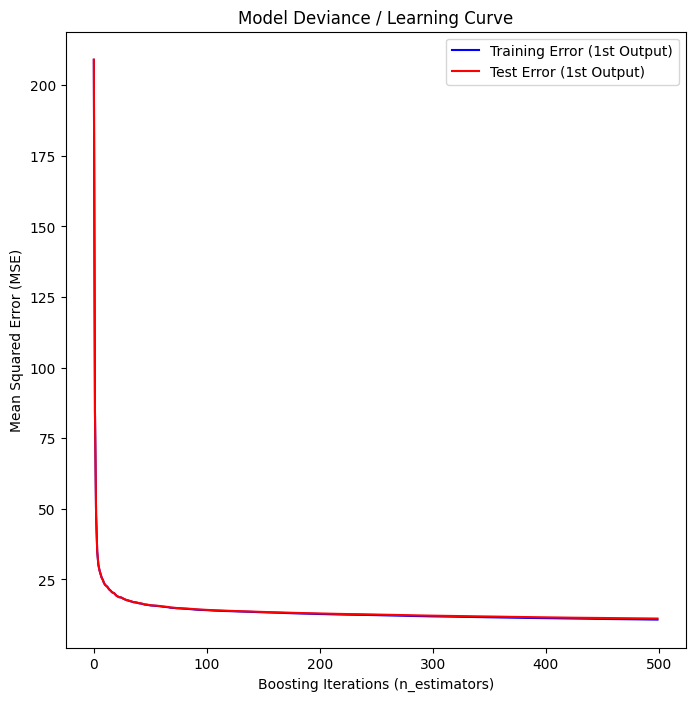

In [ ]:
first_estimator = multi_output_booster.estimators_[0]

# Select the corresponding column from the test data
y_test_first_output = y_test[:, 0]

# 1. Create an array to hold the test error at each stage
test_error = np.zeros_like(first_estimator.train_score_)

# 2. Calculate the test error for each boosting stage
#    Use the selected estimator and the corresponding y_test column
for idx, y_pred in enumerate(first_estimator.staged_predict(X_test)):
    test_error[idx] = np.mean((y_test_first_output - y_pred)**2)

# 3. Create the plot
fig, ax = plt.subplots(figsize=(8, 8))
plot_idx = np.arange(first_estimator.train_score_.shape[0])

# Plot the training score from the selected estimator
ax.plot(plot_idx,
        first_estimator.train_score_,
        'b',
        label='Training Error (1st Output)')

# Plot the test error you just calculated
ax.plot(plot_idx,
        test_error,
        'r',
        label='Test Error (1st Output)')

ax.set_title('Model Deviance / Learning Curve')
ax.set_xlabel('Boosting Iterations (n_estimators)')
ax.set_ylabel('Mean Squared Error (MSE)')
ax.legend()
plt.show()

In [ ]:
# 1. Extract the feature importances from each fitted model inside the wrapper
all_importances = [
    estimator.feature_importances_ for estimator in multi_output_booster.estimators_
]

# 2. Average the importances across all models
# axis=0 calculates the mean down each column
average_importances = np.mean(all_importances, axis=0)

# 3. Create the DataFrame using the averaged importances
feature_names = X_train.columns.tolist()
feature_imp = pd.DataFrame(
    {'importance': average_importances},
    index=feature_names
)

# 4. Sort and display the results
print(feature_imp.sort_values(by='importance', ascending=False))

                            importance
ball_land_y               4.051758e-01
ball_land_x               3.842468e-01
x_input                   1.033731e-01
y_input                   7.180396e-02
dir                       1.063968e-02
num_frames_output         6.200353e-03
s                         5.086658e-03
play_direction_encoded    3.642213e-03
role_Defensive Coverage   3.318558e-03
role_Targeted Receiver    1.362091e-03
absolute_yardline_number  1.201745e-03
player_weight             1.086599e-03
o                         8.960059e-04
a                         6.402488e-04
position_CB               3.702714e-04
player_height             2.790683e-04
position_SS               1.502324e-04
position_FS               1.191538e-04
position_OLB              1.069251e-04
position_WR               7.983764e-05
position_ILB              6.682398e-05
position_MLB              6.022110e-05
position_S                3.664927e-05
position_RB               2.312489e-05
position_DE              

Effect of Change of learning rate

In [ ]:
y_hat_boost = multi_output_booster.predict(X_test)

# This line will now work correctly
mse = np.mean((y_test - y_hat_boost)**2)

print(f"Mean Squared Error: {mse}")

Mean Squared Error: 11.505732254489745


## Data Visualisation of One tree

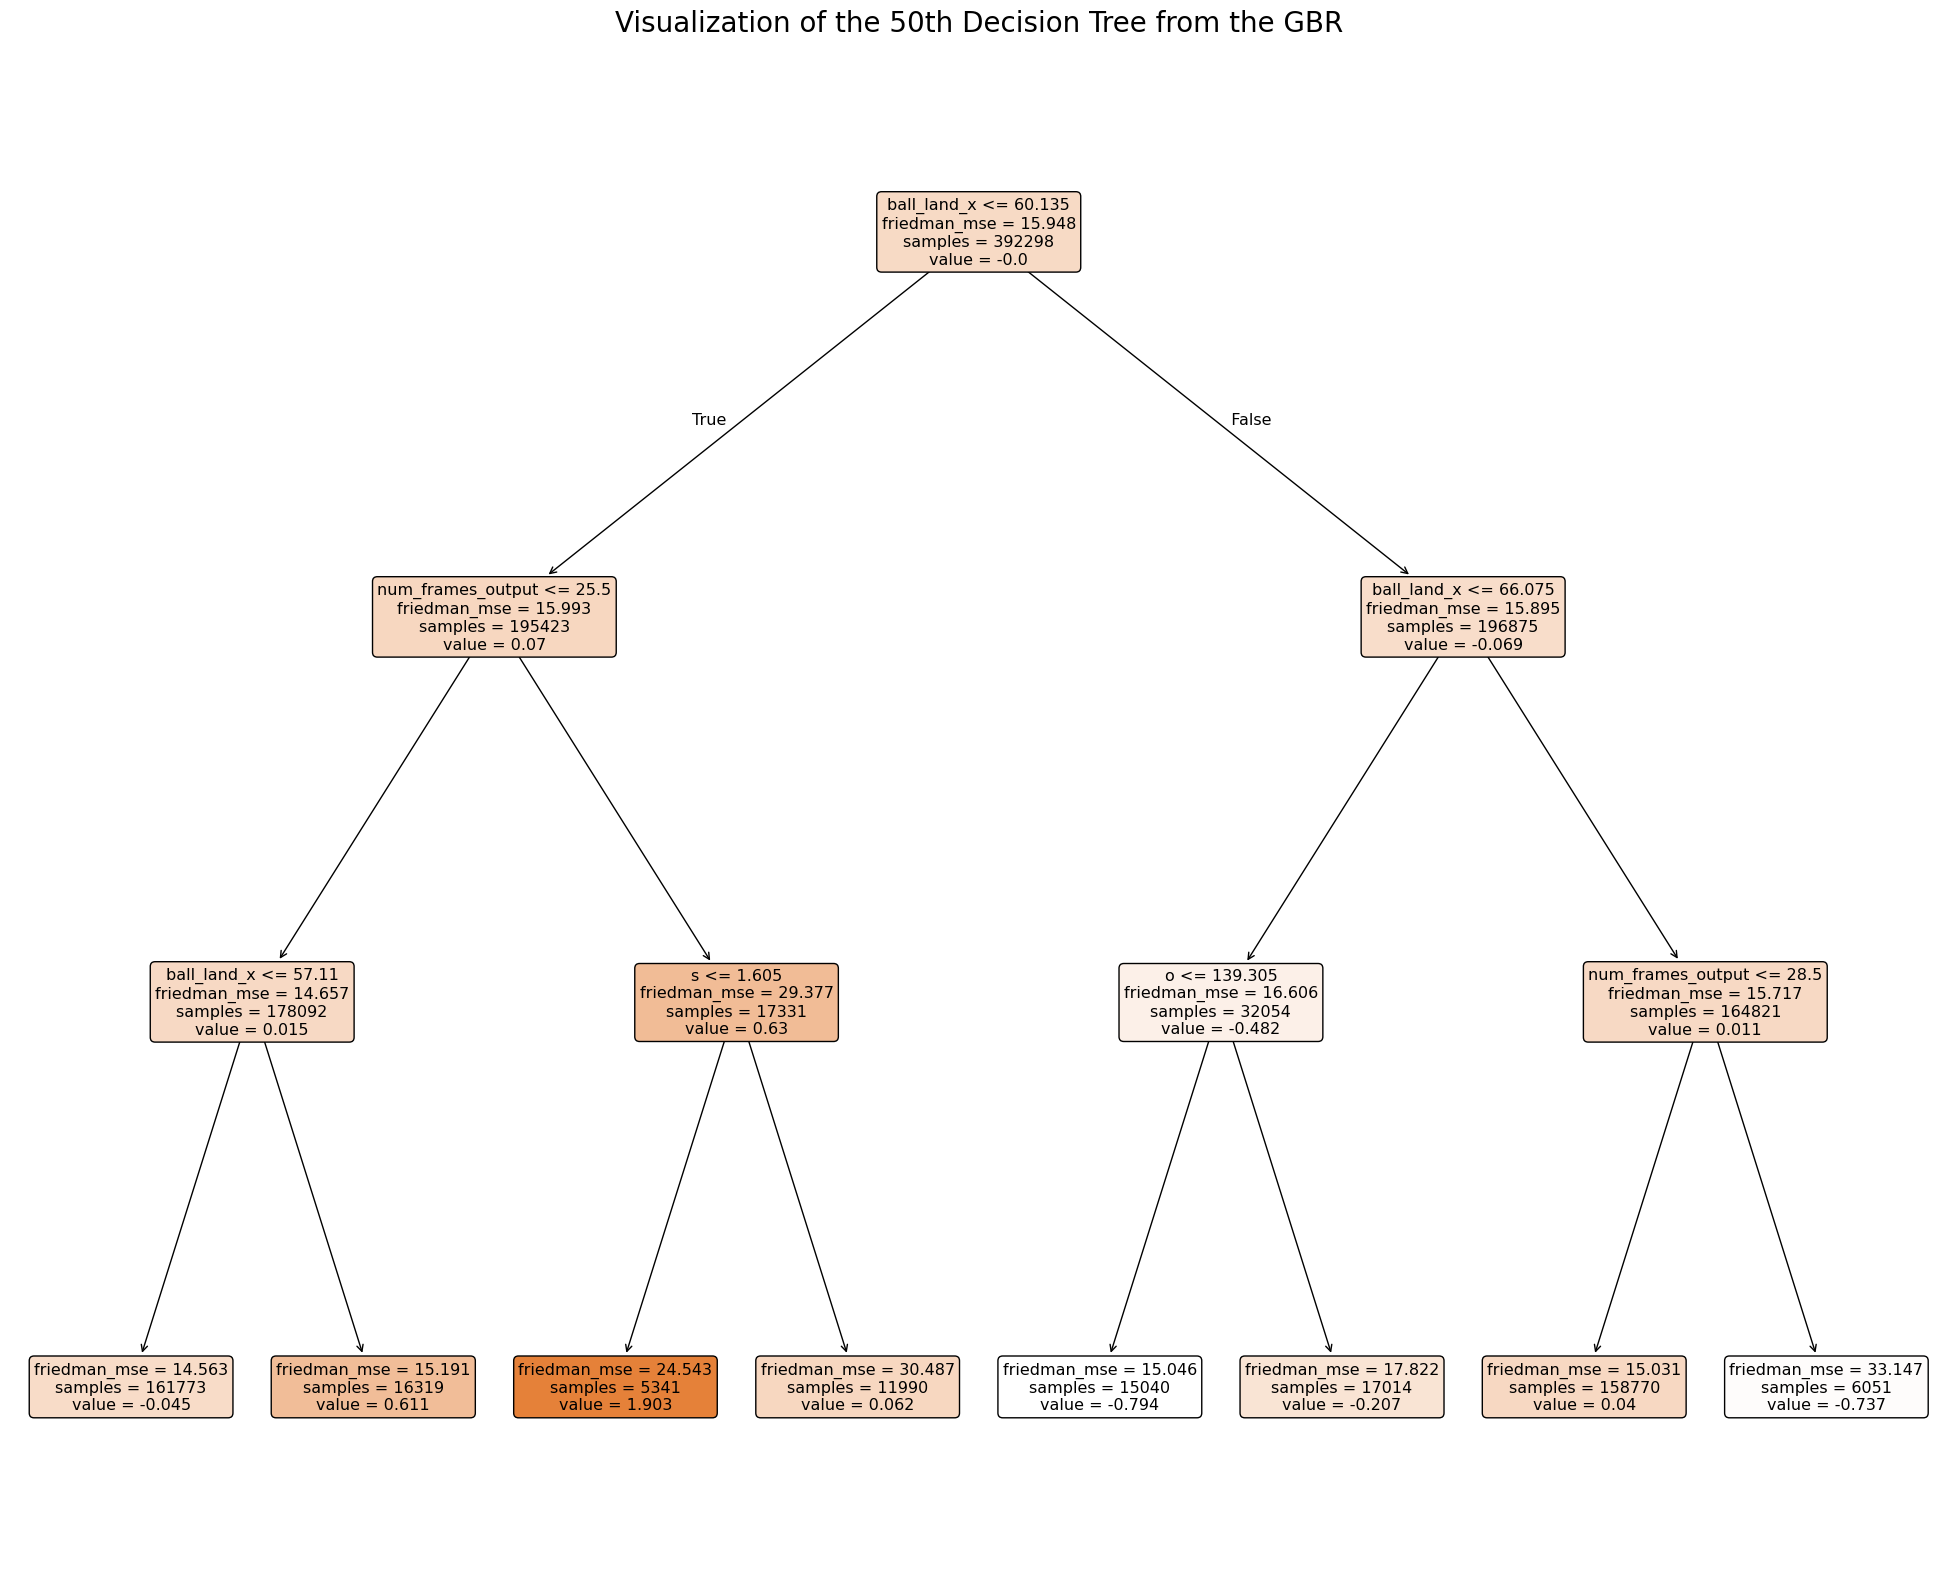

In [ ]:
# 1. Select the GBR model for the first output variable
gbr_for_first_output = multi_output_booster.estimators_[0]

# 2. Pick one of the simple trees from the GBR's sequence.
#    Let's pick the 50th tree (index 49). Early trees are often less interesting.
single_tree_from_gbr = gbr_for_first_output.estimators_[49][0]

# 3. Now, plot this single tree
plt.figure(figsize=(25, 20))
plot_tree(single_tree_from_gbr,
          feature_names=feature_names,
          filled=True,
          rounded=True)

plt.title("Visualization of the 50th Decision Tree from the GBR", fontsize=20)
plt.show()

# Model Validation

In [ ]:
param_grid = {
    'estimator__n_estimators': [100, 200, 500],
    'estimator__learning_rate': [0.01, 0.1, 0.5],
    'estimator__max_depth': [3, 5]
}

# 3. Set up the K-Fold cross-validation
kfold = skm.KFold(5, shuffle=True, random_state=10)

# 4. Set up GridSearchCV with the correct model and parameters
grid = skm.GridSearchCV(
    estimator=multi_output_booster,
    param_grid=param_grid,
    cv=kfold,
    scoring='neg_mean_squared_error'
)

# 5. Run the grid search
G = grid.fit(X_train, y_train)

# You can now see the best parameters found
print("Best Parameters:", G.best_params_)

KeyboardInterrupt: 

# Model Optimization

In [ ]:
## missing 🙀

#Discussion

# Submission

In [ ]:
# Verify prediction on sample data
sample_idx = 0
sample_input = X_test.iloc[[sample_idx]]

prediction = multi_output_booster.predict(sample_input)[0]
pred_x = prediction[0]
pred_y = prediction[1]

actual_x = y_test[sample_idx, 0]
actual_y = y_test[sample_idx, 1]

print(f"Predicted: ({pred_x:.2f}, {pred_y:.2f})")
print(f"Actual: ({actual_x:.2f}, {actual_y:.2f})")
print(f"Error: {np.sqrt((pred_x - actual_x)**2 + (pred_y - actual_y)**2):.2f}")

Predicted: (23.11, 44.37)
Actual: (23.54, 44.09)
Error: 0.52


In [ ]:
# Load test data
test_input = pd.read_csv(DATA_DIR / 'test_input.csv')
test = pd.read_csv(DATA_DIR / 'test.csv')

print(f'Test input shape: {test_input.shape}')
print(f'Test shape: {test.shape}')

# Filter only players to predict
test_input_filtered = test_input[test_input['player_to_predict'] == True].copy()
print(f'Filtered test input shape: {test_input_filtered.shape}')

Test input shape: (49753, 23)
Test shape: (5837, 4)
Filtered test input shape: (13254, 23)


In [ ]:
# Test data feature processing (same as training data)
test_input_filtered['play_direction_encoded'] = (test_input_filtered['play_direction'] == 'right').astype(int)

# player_heightConvert to numeric
test_input_filtered['player_height'] = test_input_filtered['player_height'].apply(height_to_inches)

# Rename columns to _input (match training data)
test_input_filtered = test_input_filtered.rename(columns={'x': 'x_input', 'y': 'y_input'})

# One-hot encode player_position and player_role
test_position_dummies = pd.get_dummies(test_input_filtered['player_position'], prefix='position')
test_role_dummies = pd.get_dummies(test_input_filtered['player_role'], prefix='role')

# Adjust to have same columns as training data
for col in position_dummies.columns:
    if col not in test_position_dummies.columns:
        test_position_dummies[col] = 0

for col in role_dummies.columns:
    if col not in test_role_dummies.columns:
        test_role_dummies[col] = 0

test_features = pd.concat([test_input_filtered, test_position_dummies, test_role_dummies], axis=1)

# Feature selection (same order as training data)
X_test = test_features[feature_columns].fillna(0)

print(f'Test features shape: {X_test.shape}')

Test features shape: (13254, 32)


In [ ]:
# Predict on test data
print('Predicting test data...')
test_predictions = multi_output_booster.predict(X_test)
test_pred_x = test_predictions[:, 0]
test_pred_y = test_predictions[:, 1]

# Add predictions to test_input_filtered
test_input_filtered['pred_x'] = test_pred_x
test_input_filtered['pred_y'] = test_pred_y

print(f'Predictions completed: {len(test_pred_x)} samples')
print(f'Sample predictions:')
print(test_input_filtered[['game_id', 'play_id', 'nfl_id', 'frame_id', 'pred_x', 'pred_y']].head())

Predicting test data...
Predictions completed: 13254 samples
Sample predictions:
       game_id  play_id  nfl_id  frame_id     pred_x     pred_y
45  2024120805       74   54586         1  82.949923  39.496989
46  2024120805       74   54586         2  82.932059  39.620702
47  2024120805       74   54586         3  82.663033  39.083677
48  2024120805       74   54586         4  82.413642  39.187282
49  2024120805       74   54586         5  82.500495  39.187282


In [ ]:
# submission.csvCreation
# Create ID matching test.csv format
submission = test.copy()
submission['id'] = submission['game_id'].astype(str) + '_' + \
                   submission['play_id'].astype(str) + '_' + \
                   submission['nfl_id'].astype(str) + '_' + \
                   submission['frame_id'].astype(str)

# Merge predictions
test_pred_df = test_input_filtered[['game_id', 'play_id', 'nfl_id', 'frame_id', 'pred_x', 'pred_y']].copy()
submission = submission.merge(
    test_pred_df,
    on=['game_id', 'play_id', 'nfl_id', 'frame_id'],
    how='left'
)

# Final submission format
submission_final = submission[['id', 'pred_x', 'pred_y']].rename(columns={'pred_x': 'x', 'pred_y': 'y'})

# Fill missing values with 0 (as precaution)
submission_final = submission_final.fillna(0)

# Save to CSV
submission_final.to_csv("./submission.csv", index=False)